
Early stopping occurred at epoch 45 with best_epoch = 15 and best_val_accuracy = 0.745
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


🔗 Meta-Model Accuracy: 0.785
📈 F1 Score: 0.5656565656565656
🏆 ROC AUC: 0.814404761904762

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.86       140
           1       0.72      0.47      0.57        60

    accuracy                           0.79       200
   macro avg       0.76      0.69      0.71       200
weighted avg       0.78      0.79      0.77       200



  0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

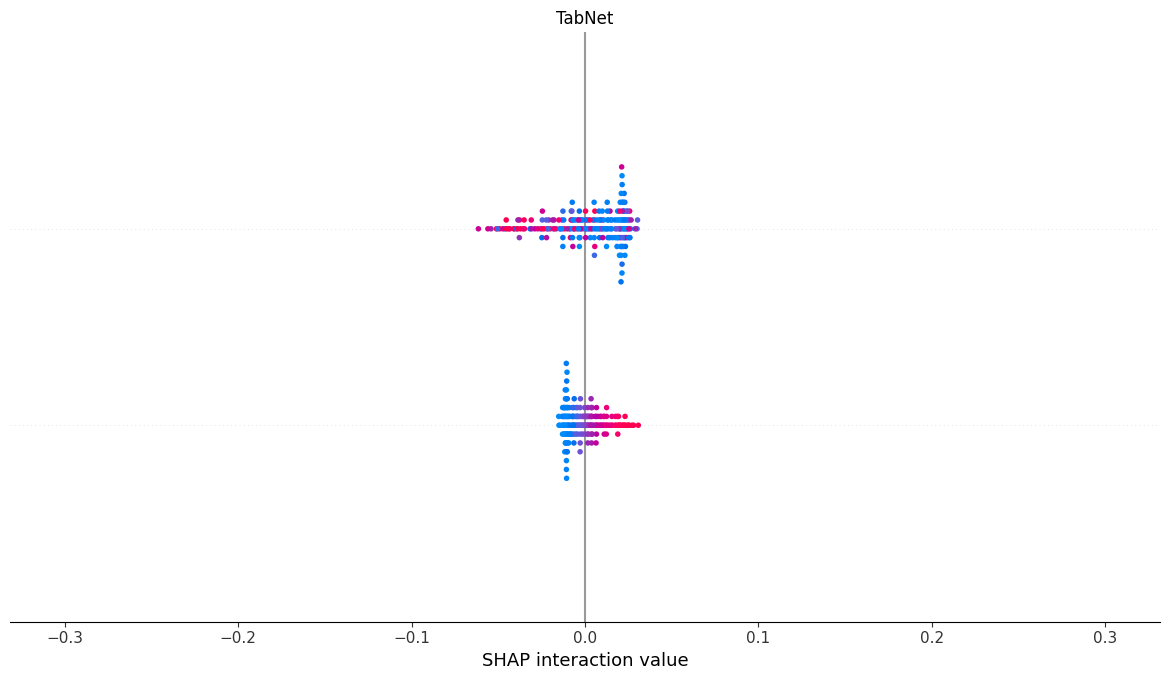

In [6]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import shap

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# === Load and Preprocess Data ===
column_names = [
    'Status_checking_account', 'Duration', 'Credit_history', 'Purpose', 'Credit_amount',
    'Savings_account_bonds', 'Employment', 'Installment_rate', 'Personal_status_and_sex',
    'Other_debtors', 'Residence_since', 'Property', 'Age', 'Other_installment_plans',
    'Housing', 'Number_credits', 'Job', 'People_liable', 'Telephone', 'Foreign_worker', 'Risk'
]
df = pd.read_csv("german.data", sep=' ', header=None, names=column_names)
df['target'] = df['Risk'].map({1: 0, 2: 1})
df.drop(columns=['Risk'], inplace=True)

categorical_cols = [
    'Status_checking_account', 'Credit_history', 'Purpose', 'Savings_account_bonds',
    'Employment', 'Personal_status_and_sex', 'Other_debtors', 'Property',
    'Other_installment_plans', 'Housing', 'Job', 'Telephone', 'Foreign_worker'
]
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['target']]

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

X = df.drop(columns=['target']).values.astype(np.float32)
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === Train Base Models ===

# 1. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50, max_depth=3)
xgb.fit(X_train, y_train)
xgb_prob = xgb.predict_proba(X_test)[:, 1]

# 2. TabNet
tabnet = TabNetClassifier(
    n_d=32, n_a=32, n_steps=5, gamma=1.5, lambda_sparse=1e-5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    seed=42, verbose=0
)
tabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=300, patience=30,
    batch_size=64, virtual_batch_size=32
)
tabnet_prob = tabnet.predict_proba(X_test)[:, 1]

# 3. MLP++
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp_model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=0, validation_split=0.2)
mlp_prob = mlp_model.predict(X_test).ravel()

# === Meta-Model Stacking ===
meta_X = np.vstack([xgb_prob, tabnet_prob, mlp_prob]).T
meta_model = LogisticRegression()
meta_model.fit(meta_X, y_test)
meta_pred = meta_model.predict(meta_X)
meta_prob = meta_model.predict_proba(meta_X)[:, 1]

# === Evaluation ===
print("🔗 Meta-Model Accuracy:", accuracy_score(y_test, meta_pred))
print("📈 F1 Score:", f1_score(y_test, meta_pred))
print("🏆 ROC AUC:", roc_auc_score(y_test, meta_prob))
print("\n📄 Classification Report:\n", classification_report(y_test, meta_pred))

# === SHAP Explainability ===
explainer = shap.KernelExplainer(meta_model.predict_proba, meta_X)
shap_values = explainer.shap_values(meta_X, nsamples=100)

shap.summary_plot(shap_values, meta_X, feature_names=["XGBoost", "TabNet", "MLP++"])
